# Anomaly detection in time series
==================================

Use-case dor the evaluation of an anomaly detection model on univariate time series.


# Overview
---------

- The dataset contains 19 time series with a 30mn frequency, that were given by human experts. They have been prepared (anonymised, rescaled) and the anomaly is always present in the last day of the series.
- **The point here** is to challenge the detection made by the experts with a model : we will test some detection models and evaluate which one would be the most useful in production : the one that detects the largest amount of anomalies among these 19 time series would be the best one for performing a day-to-day analysis in a big data environment.
- Multi-features anomaly predicition could be doable in this case



In [1]:
import os 
from typing import List, Union

import pandas as pd
import numpy as np
from datetime import timedelta
import pyarrow

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

import plotly
plotly.io.renderers.default = 'plotly_mimetype'
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
init_notebook_mode(connected=False)

from tqdm.notebook import tqdm, trange
import random
import time
import memory_profiler
%load_ext memory_profiler

In [2]:
import warnings
warnings.simplefilter('ignore')

In [3]:
import scipy.stats as stats
from sklearn.ensemble import IsolationForest

# Data
---
- **data_ts.csv** is the index file, containing the ID of the time series and the date of the anomaly
- The time series are located in **data_anonymous_rescaled**

In [195]:
df_victoires = pd.read_csv("data_TS.csv",sep=';',index_col=[0])
df_victoires.head()

DATE_LIVRAISON  ID
0     2018-05-18   0
1     2020-02-04   1
2     2020-02-12   2
3     2020-03-09   3
4     2020-06-19   4

In [196]:
def get_chroniques_df_from_idx(df_victoires, idx, verbose = 1):
    """
    Get the time serie for and idx in the index file
    """
    date, ID = df_victoires.iloc[idx][["DATE_LIVRAISON","ID"]]
    filename = f"TS_{idx}.csv"
    if verbose > 0 :
        print(date, ID)

    chronique_df = pd.read_csv("./data_anonymous_rescaled/"+filename,
                            sep=';', index_col=[0])

    return chronique_df

In [198]:
# test
chronique_df = get_chroniques_df_from_idx(df_victoires, idx=2)
chronique_df

2020-02-12 2


DATE_LIVRAISON  ID  VALEUR
0      2018-03-21 00:00:00   2     0.0
1      2018-03-21 00:30:00   2     0.0
2      2018-03-21 01:00:00   2     0.0
3      2018-03-21 01:30:00   2     0.0
4      2018-03-21 02:00:00   2     0.0
...                    ...  ..     ...
32923  2020-02-12 21:30:00   2     1.0
32924  2020-02-12 22:00:00   2     1.0
32925  2020-02-12 22:30:00   2     1.0
32926  2020-02-12 23:00:00   2     1.0
32927  2020-02-12 23:30:00   2     1.0

[32928 rows x 3 columns]

# Feature extraction


- Automatic feature extraction (with a package like Tsfresh) was not very effective : our time series are very diverse, with low cardinality, and not stationnary


In [169]:
def compute_features(df):
    """
    Compute features one-by-one even if we could do it in one line. Makes it easier to test one feature at a time and disable the other.

    """
    df['day'] = pd.to_datetime(df.DATE_LIVRAISON).dt.date.astype(str)
    
    # mean
    s = pd.DataFrame(df.groupby(['day']).VALEUR.mean())
    df = df.join(s,on='day',rsuffix='m')
    df.rename(columns={ "VALEURm":"val_mean"},inplace=True)
    # max
    s = pd.DataFrame(df.groupby(['day']).VALEUR.max())
    df = df.join(s,on='day',rsuffix='m')
    df.rename(columns={ "VALEURm":"val_max"},inplace=True)
    # stddev
    s = pd.DataFrame(df.groupby(['day']).VALEUR.std())
    df = df.join(s,on='day',rsuffix='m')
    df.rename(columns={ "VALEURm":"val_std"},inplace=True)
    # J-1 mean
    s = pd.DataFrame(df.groupby(['day']).VALEUR.mean().shift(0) - df.groupby(['day']).VALEUR.mean().shift(1))
    df = df.join(s,on='day',rsuffix='m')
    df.rename(columns={ "VALEURm":"J-1_mean"},inplace=True)
    return df

# Visualization
- Plotly viz for a sample of n time series
- matplotlib viz of the history (<3years) on the left, and lat 15 days on the right

In [211]:
def plot_VP(df_chr,
            titre=None,
#             col = None,
            ):
    """
    plotly of one TS at a time
    
    """
    if titre == None :
        date, ID = df_chr.iloc[-1,:][["day","ID"]].tolist()
        titre = f"anomaly @{date}  for Time Serie id={ID}"
    col_feature = "black"
    col = None
    col_anomaly = 'red'
    
    # col=(None if victories else "#ffa15a")
    fig = go.Figure(data=[go.Scattergl(x=df_chr['DATE_LIVRAISON'], 
                                     y=df_chr["VALEUR"],
                                     name="Time series",
                                     line=dict(color=col)
                                    )])
       
    fig.add_trace(go.Scatter(name="Anomaly",
           x=df_chr.iloc[-48:,:]['DATE_LIVRAISON'],
           y=df_chr.iloc[-48:,:]['VALEUR'],
           mode='markers',
           marker_symbol = 'cross',
           xaxis='x1',
           yaxis='y1',
           marker=dict(color=col_anomaly,
                       size=7,
                       line=dict(color=col_anomaly,width=1))
                        ),
           )
    
    fig.update_layout(
        width=700, height=300,
        title=titre,
        xaxis_title="Date",
        font=dict(
            size=10,
            color="black"
        ),
        title_x=0.075
        ,
        title_y=0.95,
        margin=dict(l=2, r=2, b=10, t=10,
                                      # pad=1
                                      ),
        )
    iplot(fig)

In [212]:
def plot_random_VP(df_victoires, n=5):
    liste_random_vp = random.sample(df_victoires.index.tolist(), n)
    for i in sorted(liste_random_vp):
        chronique_df = get_chroniques_df_from_idx(df_victoires, idx=i, verbose = 0)
        chronique_df = compute_features(chronique_df)
        plot_VP(chronique_df,
                )
        
def plot_VP_with_idx(df_victoires, i=5):
    chronique_df = get_chroniques_df_from_idx(df_victoires, idx=i, verbose = 0)
    chronique_df = compute_features(chronique_df)
    plot_VP(chronique_df,
                )
        


In [213]:
plotly.io.renderers.default = 'iframe'

In [214]:
plot_random_VP(df_victoires, n=2)

In [215]:
def visualize_all_pyplot(df_victoires, indexes=[]):
    if len(indexes) ==2 :
        index_debut, index_fin=indexes 
    else :
        index_debut, index_fin = [0,len(df_victoires)]
    i=0
    fig, ax = plt.subplots(len(df_victoires[index_debut:index_fin]),2, figsize=(20,9*len(df_victoires[index_debut:index_fin])), gridspec_kw={'width_ratios': [3, 1]})
    for v in df_victoires.index[index_debut:index_fin]:
        date, ID = df_victoires.iloc[v][["DATE_LIVRAISON","ID"]]
        date = pd.to_datetime(date) 
        date_min = pd.to_datetime(date) - pd.Timedelta(days=1095)
        date_15j = pd.to_datetime(date) - pd.Timedelta(days=15)
        
        

        chronique_df = get_chroniques_df_from_idx(df_victoires, idx=v, verbose = 0)
        chronique_df = compute_features(chronique_df)
        # feature_df = feature_df[feature_df['FEATURE']==feature]
        chronique_df.DATE_LIVRAISON = pd.to_datetime(chronique_df.DATE_LIVRAISON)
        chronique_df.day = pd.to_datetime(chronique_df.day)
        # feature_df.DATE_LIVRAISON = pd.to_datetime(feature_df.DATE_LIVRAISON)
        chronique_df = chronique_df[(chronique_df.day <= date + pd.Timedelta(days=1) ) & (chronique_df.DATE_LIVRAISON > date_min)]
        # feature_df = feature_df[(feature_df.DATE_LIVRAISON <= date + pd.Timedelta(days=2)) & (feature_df.DATE_LIVRAISON > date_min)]

        sns.lineplot(chronique_df.DATE_LIVRAISON, chronique_df.VALEUR,
                     ax=ax[i,0])
        sns.lineplot(chronique_df[(chronique_df.day <= date ) & (chronique_df.DATE_LIVRAISON > date_15j)].DATE_LIVRAISON,
                     chronique_df[(chronique_df.day <= date ) & (chronique_df.DATE_LIVRAISON > date_15j)].VALEUR, 
                     ax=ax[i,1])
        # sns.scatterplot(feature_df[(feature_df.DATE_LIVRAISON <= date + pd.Timedelta(days=2)) & (feature_df.DATE_LIVRAISON > date_15j)].DATE_LIVRAISON,
        #                 feature_df[(feature_df.DATE_LIVRAISON <= date + pd.Timedelta(days=2)) & (feature_df.DATE_LIVRAISON > date_15j)]['VALEUR'], 
        #                 ax=ax[i,1], color =  'k')
        sns.scatterplot(chronique_df[(chronique_df.day >= date) ].DATE_LIVRAISON,
                        chronique_df[(chronique_df.day >= date) ].VALEUR, 
                        ax=ax[i,0], color =  'red', marker = "X", s=100)
        sns.scatterplot(chronique_df[(chronique_df.DATE_LIVRAISON >= date ) ].DATE_LIVRAISON,
                        chronique_df[(chronique_df.DATE_LIVRAISON >= date ) ]['VALEUR'], 
                        ax=ax[i,1], color =  'red', marker = "X", s=100)
        
        ax[i,0].set_title(f"anomaly @{date}    for TS id={ID} ")
        ax[i,0].xaxis.set_major_locator(mdates.MonthLocator(interval=2))
        ax[i,1].xaxis.set_major_locator(mdates.DayLocator(interval=1))
        ax[i,0].xaxis.set_minor_locator(mdates.MonthLocator(interval=1))
        ax[i,0].tick_params(axis='x', labelrotation=90 )
        ax[i,1].tick_params(axis='x', labelrotation=90 )
        i+=1
    plt.show()

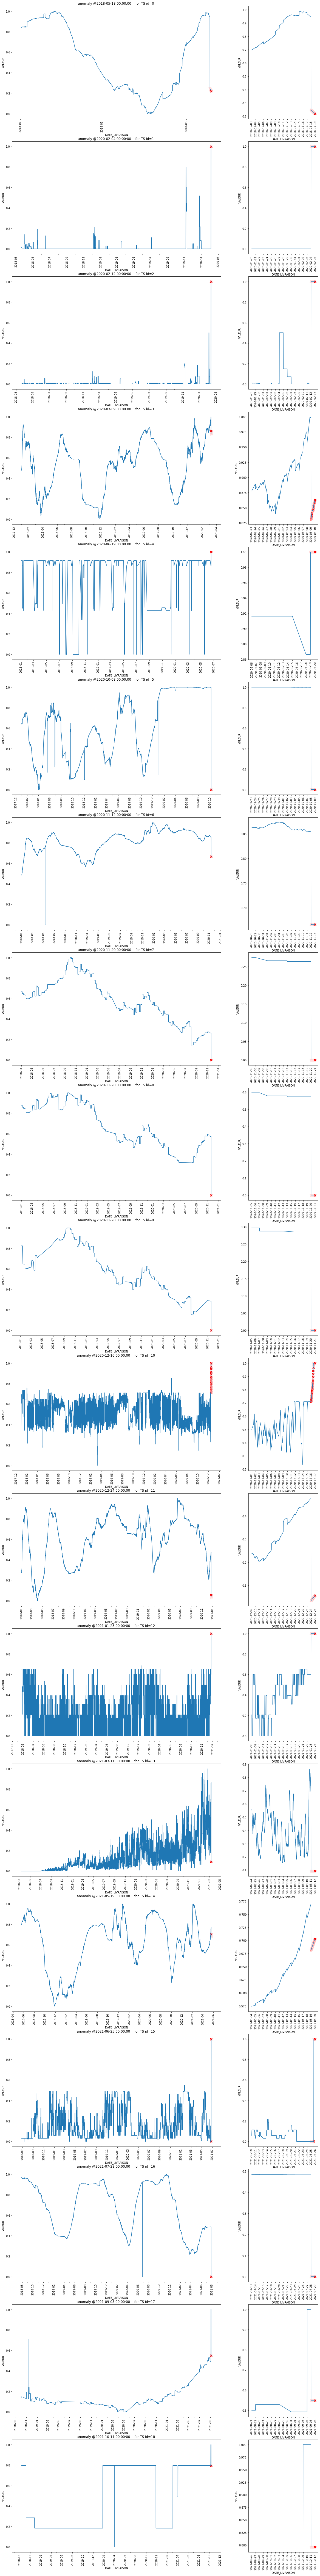

In [216]:
visualize_all_pyplot(df_victoires)

# Evaluation functions
----
Here each model will be fitted on each time serie : no generalization is possible

In [217]:
def compute_score_on_feature(model, sample: List[float], test: float, depth: int) -> float:
    sample_set = set(sample)
    nb_uniques = len(sample_set)

    if nb_uniques == 0:
        # Cas hyper-particulier, ne doit normalement jamais arriver en exploitation
        return 0 if test is not None else 200
    elif nb_uniques == 1:
        # Cas où l'historique est constant
        return 0 if test not in sample_set else 100
    else:
        # depth of the history
        sample_ = sample[-depth:]
        
        # Model
        if model == "iforest" :
            # isolation forest
            # classic model for univariate/multivariate data
            clf = IsolationForest(n_estimators=100,
                                  contamination=0.00001,
                                  random_state=42,
                                  )


            train_set = np.array(sample_+[test]).reshape(-1, 1)
            clf.fit(train_set)

            scores = clf.decision_function(train_set).astype(float)

            # basic rescale from [-0.5, 0.5] to [0.,1.]
            scores = scores + 0.5
            return scores[-1]
        elif model == 'kde' :
            try:
                kde = stats.gaussian_kde(sample_, bw_method='scott')
                return float(kde.pdf(test)) * np.std(sample_)
            except Exception as e:
                print(e)
                return -1
        elif model == 'luminol_bitmap' :
            #luminol is a linkedin model, not implemented here
            return -1



In [218]:
def compute_score(df, model, on_feature=True, depth=1095):
    """
    Computation on the time serie itself is deactivated at the moment : we only comput
    """
    if model not in ['iforest','kde']:
        raise Exception('Model not available')
    n = 1 if on_feature else 48
    sample = df.VALEUR.values.tolist()[:-n]
    if on_feature :
        test = df.VALEUR.values[-n]
        score = compute_score_on_feature(model,sample, test, depth)
    else :
        raise Exception('Can only evaluate the anomaly score on pre-computed features')
    return score

In [219]:
def verticalize(df):
    feature_df = df[df.columns.difference(['DATE_LIVRAISON', 'VALEUR'])].set_index(['ID','day']).drop_duplicates().stack().to_frame().rename(columns={0:'VALEUR'})
    feature_df.reset_index(inplace=True)
    feature_df.columns=['ID' ,'day','FEATURE','VALEUR']
    return feature_df

# Anomaly score computation for all features
--- 
- Get the anomaly scores for our 2 models, for each feature, for each serie
- get the min score among the features, get the best model

In [185]:
def evaluate_model_on_known_anomalies(df_victoires, model):
    i=0
    duration = 0
    scores_df = pd.DataFrame()
    for v in df_victoires.index :
        try :
            chronique_df = get_chroniques_df_from_idx(df_victoires, idx=v)
            df = compute_features(chronique_df)
            feature_df = verticalize(df)
        except :
            print("Could not get the data")
            pass
        try :
            ti = time.time()
            scores = pd.DataFrame(feature_df.groupby(["ID","FEATURE"]).apply(lambda x: compute_score(x,model=model)).rename('SCORE'))
            duration += (time.time() - ti)
            i+=1
        except Exception as e :
            print(e)
            print("Impossible de calculer les scores")
            scores = pd.DataFrame(feature_df.groupby(["ID","FEATURE"]).apply(lambda x: -1).rename('SCORE'))
            pass
        scores['DATE_LIVRAISON']  =df_victoires.iloc[v,:]["DATE_LIVRAISON"]
        scores_df = pd.concat([scores_df,scores.reset_index()],axis=0)
    scores_df = scores_df[['DATE_LIVRAISON','ID','FEATURE','SCORE']]
    print("nombre de VP traités : ",i, "en ",duration)
    assert duration <= 120, "TEMPS DE CALCUL SUPERIEUR A iForest"
    return scores_df
# scoring : 2s sur 65 VP avec kde, 335s pour iForest
# avec groupby : 1s avec kde, 110 avec iforest

In [186]:
# %%memit -r 3
scores_df = pd.DataFrame()
for m in ['kde','iforest']:
    d = evaluate_model_on_known_anomalies(df_victoires,m)
    d['DETECTOR'] = m
    scores_df = pd.concat([scores_df,d])


2018-05-18 0
2020-02-04 1
2020-02-12 2
2020-03-09 3
2020-06-19 4
2020-10-08 5
2020-11-12 6
2020-11-20 7
2020-11-20 8
2020-11-20 9
2020-12-16 10
2020-12-24 11
2021-01-23 12
2021-03-11 13
2021-05-19 14
2021-06-25 15
2021-07-28 16
2021-09-05 17
2021-10-11 18
nombre de VP traités :  19 en  0.20078706741333008
2018-05-18 0
2020-02-04 1
2020-02-12 2
2020-03-09 3
2020-06-19 4
2020-10-08 5
2020-11-12 6
2020-11-20 7
2020-11-20 8
2020-11-20 9
2020-12-16 10
2020-12-24 11
2021-01-23 12
2021-03-11 13
2021-05-19 14
2021-06-25 15
2021-07-28 16
2021-09-05 17
2021-10-11 18
nombre de VP traités :  19 en  21.87070107460022


In [187]:
scores_df

DATE_LIVRAISON  ID   FEATURE       SCORE DETECTOR
0      2018-05-18   0  J-1_mean    0.000000      kde
1      2018-05-18   0   val_max    0.345101      kde
2      2018-05-18   0  val_mean    0.344897      kde
3      2018-05-18   0   val_std    0.215605      kde
0      2020-02-04   1  J-1_mean    0.000021      kde
..            ...  ..       ...         ...      ...
3      2021-09-05  17   val_std  100.000000  iforest
0      2021-10-11  18  J-1_mean    0.690330  iforest
1      2021-10-11  18   val_max    0.763592  iforest
2      2021-10-11  18  val_mean    0.763592  iforest
3      2021-10-11  18   val_std  100.000000  iforest

[152 rows x 5 columns]

In [220]:
scores_df = scores_df[scores_df["SCORE"] >= 0]
scores_df.reset_index(inplace=True, drop=True)
indexes = scores_df.groupby(["DATE_LIVRAISON", "ID", "DETECTOR"]).SCORE.idxmin()
indexes = indexes.dropna()
scores_df = scores_df.loc[indexes].reset_index(drop=True)


A threshold of 1E-7 has been chosen here for the kde detector, while the iforest detection rely on a good choice of the contamination parameter.

In [224]:
scores_df['ANOMALY'] = ((scores_df['DETECTOR'] == 'kde') & (scores_df['SCORE'] <= 0.0000001)) \
                                    | ((scores_df['DETECTOR'] == 'iforest') & (scores_df['SCORE'] < 0.5))
scores_df

DATE_LIVRAISON  ID   FEATURE         SCORE DETECTOR  ANOMALY
0      2018-05-18   0  J-1_mean  4.997644e-01  iforest     True
1      2018-05-18   0  J-1_mean  0.000000e+00      kde     True
2      2020-02-04   1   val_max  4.999466e-01  iforest     True
3      2020-02-04   1  val_mean  1.510106e-05      kde    False
4      2020-02-12   2  val_mean  4.998263e-01  iforest     True
5      2020-02-12   2   val_max  0.000000e+00      kde     True
6      2020-03-09   3  J-1_mean  5.154217e-01  iforest    False
7      2020-03-09   3  J-1_mean  5.800002e-60      kde     True
8      2020-06-19   4  val_mean  4.999943e-01  iforest     True
9      2020-06-19   4  val_mean  2.679125e-01      kde    False
10     2020-10-08   5  J-1_mean  4.999162e-01  iforest     True
11     2020-10-08   5  J-1_mean  4.465325e-49      kde     True
12     2020-11-12   6  J-1_mean  5.751009e-01  iforest    False
13     2020-11-12   6  J-1_mean  2.703953e-85      kde     True
14     2020-11-20   7   val_max  4.995898e-01  iforest     True
15     2020-11-20   7  J-1_mean  2.067465e-24      kde     True
16     2020-11-20   8   val_max  4.995002e-01  iforest     True
17     2020-11-20   8  J-1_mean  0.000000e+00      kde     True
18     2020-11-20   9   val_max  4.995350e-01  iforest     True
19     2020-11-20   9  J-1_mean  2.076063e-23      kde     True
20     2020-12-16  10   val_max  4.998801e-01  iforest     True
21     2020-12-16  10   val_max  1.847373e-11      kde     True
22     2020-12-24  11  J-1_mean  5.523616e-01  iforest    False
23     2020-12-24  11  J-1_mean  0.000000e+00      kde     True
24     2021-01-23  12  val_mean  4.996776e-01  iforest     True
25     2021-01-23  12  val_mean  4.156793e-18      kde     True
26     2021-03-11  13  J-1_mean  4.999048e-01  iforest     True
27     2021-03-11  13  J-1_mean  1.424057e-05      kde    False
28     2021-05-19  14  J-1_mean  5.311004e-01  iforest    False
29     2021-05-19  14  J-1_mean  5.513852e-11      kde     True
30     2021-06-25  15   val_max  4.996014e-01  iforest     True
31     2021-06-25  15   val_std  0.000000e+00      kde     True
32     2021-07-28  16   val_max  4.999888e-01  iforest     True
33     2021-07-28  16  J-1_mean  0.000000e+00      kde     True
34     2021-09-05  17  J-1_mean  5.278527e-01  iforest    False
35     2021-09-05  17  J-1_mean  4.785464e-12      kde     True
36     2021-10-11  18  J-1_mean  6.903305e-01  iforest    False
37     2021-10-11  18   val_max  3.007841e-01      kde    False

In [225]:
scores_df[scores_df['DETECTOR'] == 'iforest'].ANOMALY.value_counts()

True     13
False     6
Name: ANOMALY, dtype: int64

In [226]:
scores_df[scores_df['DETECTOR'] == 'kde'].ANOMALY.value_counts()

True     15
False     4
Name: ANOMALY, dtype: int64

We can conclude here that the statistical model seems to be more accurate, with 15 detections on 19 series.

A combination of the 2 models would be a good option

# Visualization : Dash app (Private)
---
This Dash application has to stay private, but here are ewamples of screenshots of how we can plot the series, features, and model's scores.
This webapp icludes :
- Multiple Hbase queries to get the time serie and the features from the cluster, with a depth of 3 years
- Choice of the feature to plot and the date (last point of the time serie) at which we want to compute the anomaly score
- Choice of models and hyperparameters
- Evaluation of the anomaly scores
- multiple plotly plots

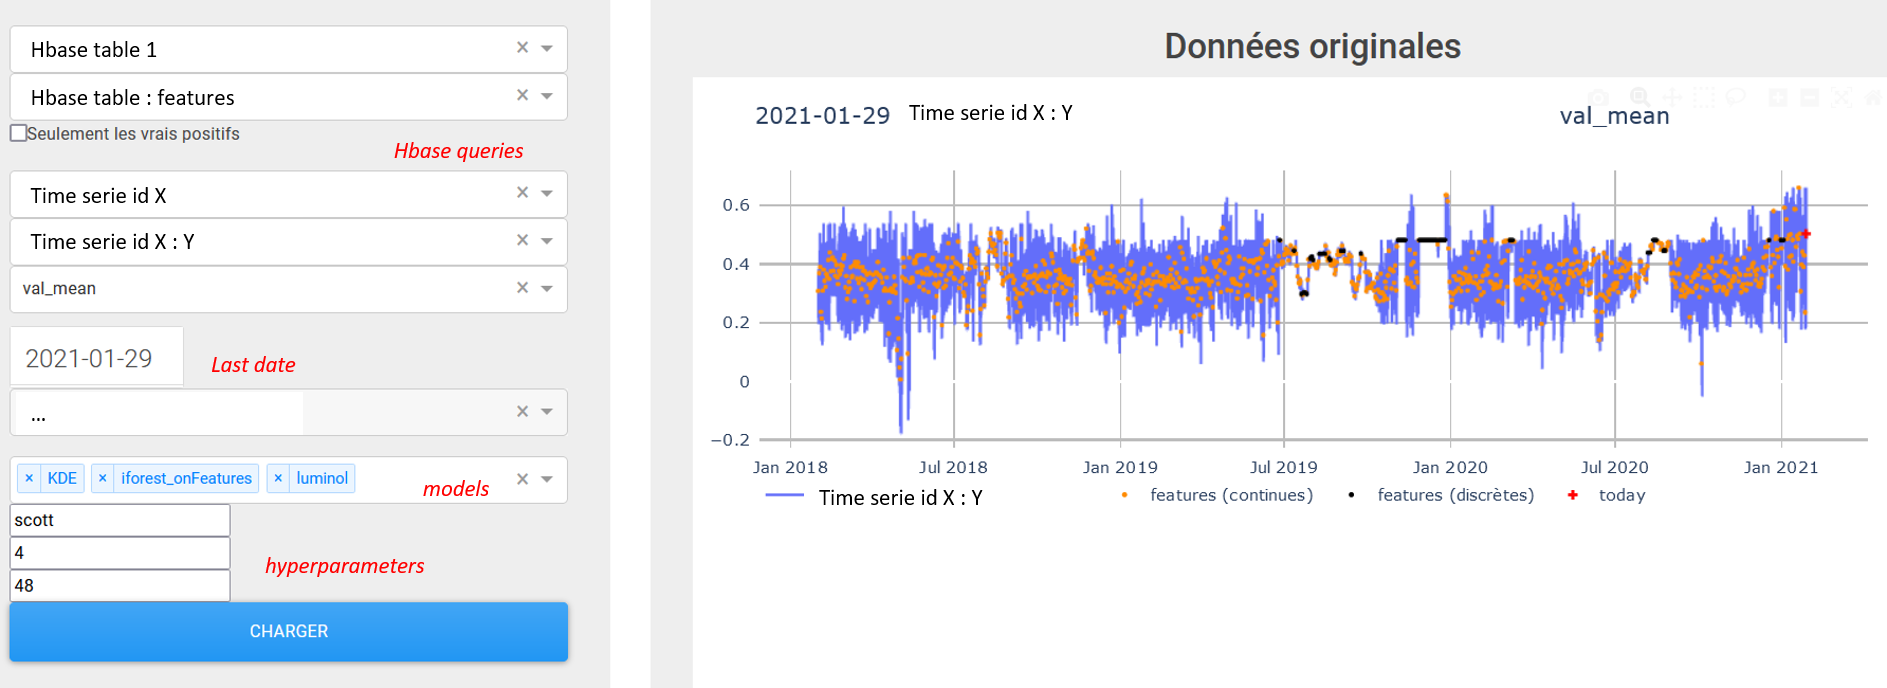

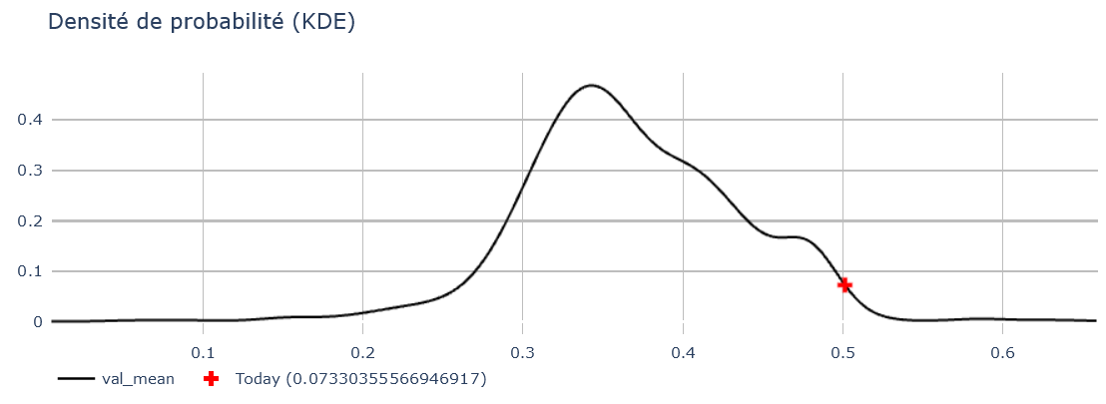

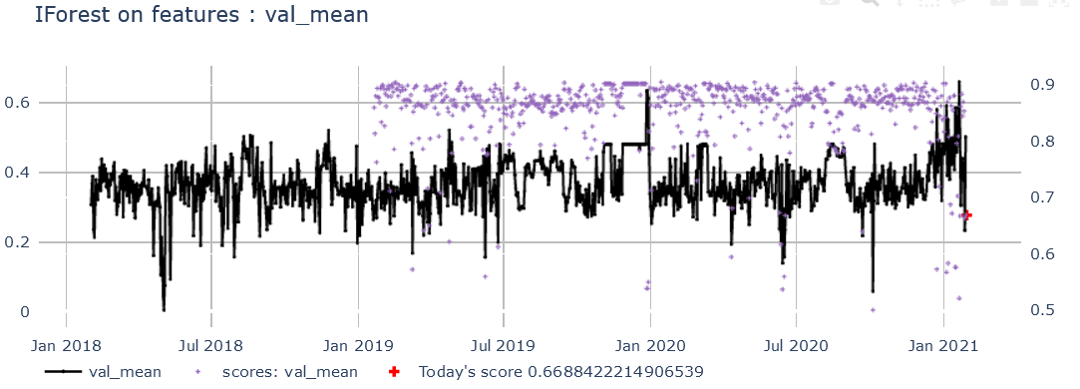